# Feature Selection and Preprocessing of Dataset

In [16]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Load the merged dataset
data = pd.read_csv('merged_dataset.csv')

# Define feature variables X and target variable y
# Assume 'Ligand ID' is the index column and should not be used as a feature, and 'ln(dr)' is the target variable
X = data.drop(columns=['Ligand ID', 'ln(dr)'])  # Remove Ligand ID and ln(dr)
y = data['ln(dr)']  # The target variable is ln(dr)

# Check for features with zero variance
zero_variance = X.var() == 0
print(f"Features with zero variance: {X.columns[zero_variance]}")

# Remove features with zero variance
X_non_zero_var = X.loc[:, X.var() != 0]

print(f"Shape of data after removing zero variance features: {X_non_zero_var.shape}")

# Use SelectKBest to select the 30 most important features
selector = SelectKBest(score_func=f_regression, k=30)
X_selected = selector.fit_transform(X_non_zero_var, y)

# Get the names of the selected features
selected_features = X_non_zero_var.columns[selector.get_support()]

# Build a new DataFrame to save the selected features
selected_df = pd.DataFrame(X_selected, columns=selected_features)
selected_df['ln(dr)'] = y.values  # Add the target variable

# Save the selected features
selected_df.to_csv('selected_features_combinDFT+RDkit.csv', index=False)
X = selected_df.drop(columns=['ln(dr)'])

print(f"Shape of data after feature selection: {selected_df.shape}")
print(f"Shape of X after feature selection: {X.shape}")
print(f"Selected features: {selected_features}")


Features with zero variance: Index([], dtype='object')
Shape of data after removing zero variance features: (77, 192)
Shape of data after feature selection: (77, 31)
Shape of X after feature selection: (77, 30)
Selected features: Index(['SPS_L', 'NumRadicalElectrons_L', 'MaxPartialCharge_L', 'PEOE_VSA1_L',
       'PEOE_VSA10_L', 'PEOE_VSA11_L', 'PEOE_VSA14_L', 'PEOE_VSA4_L',
       'SlogP_VSA1_L', 'SlogP_VSA12_L', 'TPSA_L', 'EState_VSA9_L',
       'VSA_EState2_L', 'VSA_EState4_L', 'NOCount_L',
       'NumAliphaticHeterocycles_L', 'NumHAcceptors_L', 'fr_Imine_L',
       'fr_bicyclic_L', 'ODI_HOMO_1_Free', 'ODI_HOMO_Free', 'ODI_Mean_Free',
       'ODI_Std_Free', 'ALIEmin_Free', 'ODI_HOMO_Res', 'ODI_Std_Res',
       'ESPmin_Res', 'ALIEmin_Res', 'Co_Mulliken_CoL2', 'Co_NPA_CoL2'],
      dtype='object')


# Machine Learning Model Training and Evaluation Using Cross-Validation

In [18]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np

# Standardize the data
scaler = StandardScaler()

# Define the list of models to be tested, using a pipeline to combine standardization and model training
models = {
    'LinearRegression': make_pipeline(StandardScaler(), LinearRegression()),
    'Ridge': make_pipeline(StandardScaler(), Ridge(alpha=1.0, max_iter=5000)),
    'Lasso': make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=5000)),
    'ElasticNet': make_pipeline(StandardScaler(), ElasticNet(alpha=0.01, max_iter=5000)),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Bagging': BaggingRegressor(),
    'ExtraTrees': ExtraTreesRegressor(),
    'SVR': make_pipeline(StandardScaler(), SVR()),
    'KNeighbors': make_pipeline(StandardScaler(), KNeighborsRegressor()),
    'DecisionTree': DecisionTreeRegressor(),
    'MLP': make_pipeline(StandardScaler(), MLPRegressor(max_iter=1000)),
    'XGBoost': XGBRegressor(),
    'GaussianProcess': GaussianProcessRegressor()
}

# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Custom scoring metrics
scorers = {
    'MSE': make_scorer(mean_squared_error),
    'MAE': make_scorer(mean_absolute_error),
    'R2': make_scorer(r2_score)
}

# Initialize a dictionary to store the cross-validation results for each model
results = {}

# Train and evaluate each model using 5-fold cross-validation
for name, model in models.items():
    print(f"Training model: {name}")
    
    # Perform 5-fold cross-validation and calculate the average MSE, MAE, and R2
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['MSE'])
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['MAE'])
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=scorers['R2'])
    
    # Calculate Root Mean Square Error (RMSE)
    rmse_scores = np.sqrt(mse_scores)
    
    # Calculate the average value for each metric
    results[name] = {
        'MSE': np.mean(mse_scores),
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'R2': np.mean(r2_scores)
    }
    
    print(f"{name}: MSE = {np.mean(mse_scores)}, RMSE = {np.mean(rmse_scores)}, MAE = {np.mean(mae_scores)}, R2 = {np.mean(r2_scores)}")

# Output the results as a DataFrame
results_df = pd.DataFrame(results).T  # Transpose to make model names as row labels
print(results_df)

# Save the model evaluation results to a CSV file
results_df.to_csv('model_comparison_cross_validation_results.csv', index=True)


Training model: LinearRegression
LinearRegression: MSE = 2.5338212177916484, RMSE = 1.3438436629532122, MAE = 0.8632631010988403, R2 = -0.19242361399488844
Training model: Ridge
Ridge: MSE = 0.3836311026270895, RMSE = 0.5941578517617209, MAE = 0.44981740231416517, R2 = 0.8187896088203
Training model: Lasso
Lasso: MSE = 0.354195744699711, RMSE = 0.5791067350573126, MAE = 0.44426749228847334, R2 = 0.824583190647972
Training model: ElasticNet
ElasticNet: MSE = 0.40938151805721573, RMSE = 0.6183202950690893, MAE = 0.4676329577765026, R2 = 0.8036212652822761
Training model: RandomForest
RandomForest: MSE = 0.2293361108583333, RMSE = 0.47111386059769433, MAE = 0.38333383333333326, R2 = 0.8762921951099593
Training model: GradientBoosting
GradientBoosting: MSE = 0.22459110089016399, RMSE = 0.4616330651150397, MAE = 0.370490037338838, R2 = 0.8883953322573468
Training model: AdaBoost
AdaBoost: MSE = 0.24215495807671078, RMSE = 0.4826003333605577, MAE = 0.3824154670808613, R2 = 0.8671256669672985

# Feature Importance and Cross-Validation with GradientBoostingRegressor

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
data = pd.read_csv('selected_features_combinDFT+RDkit.csv')

# Data preprocessing
X = data.drop(columns=['ln(dr)'])  # Features are descriptors, remove 'ln(dr)'
y = data['ln(dr)']  # Target variable is 'ln(dr)'

# Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mse, r2

# Initialize GradientBoostingRegressor model
et = GradientBoostingRegressor(random_state=50)

# Fit the model and obtain feature importances
et.fit(X_scaled, y)
importances = et.feature_importances_

# Rank the features by importance
indices = np.argsort(importances)[::-1]

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Store true and predicted values for each fold
y_true_all = []
y_pred_all = []

# List to store results
results = []

# Incrementally train with an increasing number of top features (from 1 to 10)
for i in range(1, 11):
    selected_features = X_scaled[:, indices[:i]]  # Select the top i most important features
    
    maes, rmses, mses, r2s = [], [], [], []
    
    # 5-fold cross-validation
    for train_index, test_index in kf.split(selected_features):
        X_train, X_test = selected_features[train_index], selected_features[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        et.fit(X_train, y_train)
        y_pred = et.predict(X_test)
        
        # Evaluate the model
        mae, rmse, mse, r2 = evaluate_model(y_test, y_pred)
        maes.append(mae)
        rmses.append(rmse)
        mses.append(mse)
        r2s.append(r2)
        
        # Combine true and predicted values
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)
    
    # Calculate average evaluation metrics
    results.append({
        'n_features': i,
        'MAE': np.mean(maes),
        'RMSE': np.mean(rmses),
        'MSE': np.mean(mses),
        'R2': np.mean(r2s)
    })

# Convert results to a DataFrame and sort
results_df = pd.DataFrame(results)

# Print the best result based on the highest R²
best_result = results_df.loc[results_df['R2'].idxmax()]
print("Best result based on R2:")
print(best_result)
best_n_features = int(best_result['n_features'])

# Show all evaluation results for each feature combination
print("Evaluation results for all feature combinations:")
print(results_df)


Best result based on R2:
n_features    6.000000
MAE           0.324412
RMSE          0.421781
MSE           0.187081
R2            0.905028
Name: 5, dtype: float64
Evaluation results for all feature combinations:
   n_features       MAE      RMSE       MSE        R2
0           1  0.570220  0.711509  0.520908  0.713611
1           2  0.506789  0.636907  0.409436  0.755929
2           3  0.443907  0.529503  0.286619  0.844991
3           4  0.426531  0.513942  0.267960  0.832963
4           5  0.364060  0.457453  0.217748  0.886396
5           6  0.324412  0.421781  0.187081  0.905028
6           7  0.353691  0.443628  0.205915  0.896469
7           8  0.357136  0.440186  0.207987  0.898972
8           9  0.355645  0.440590  0.205437  0.898006
9          10  0.369327  0.460185  0.222446  0.888797


# Visualization of Feature Importance and Model Evaluation

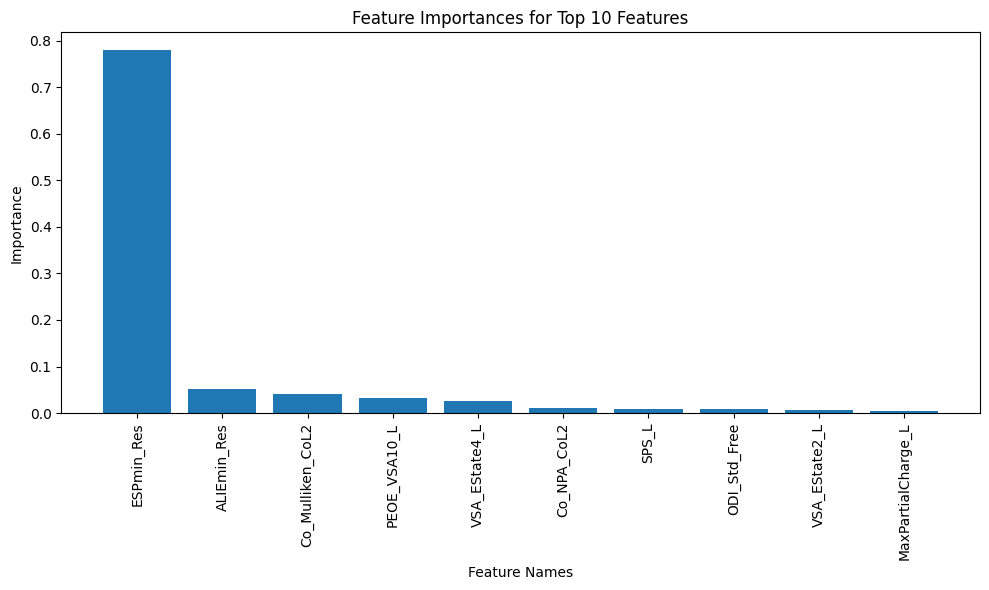

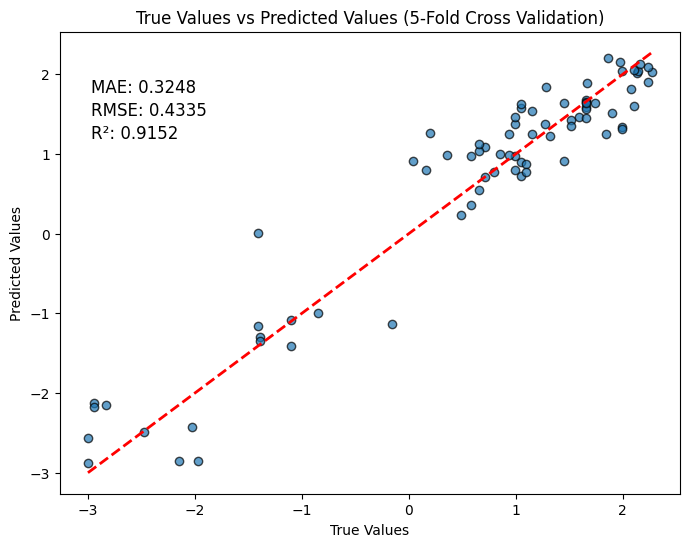

Data has been saved to 'true_vs_predicted_values_comb.csv'


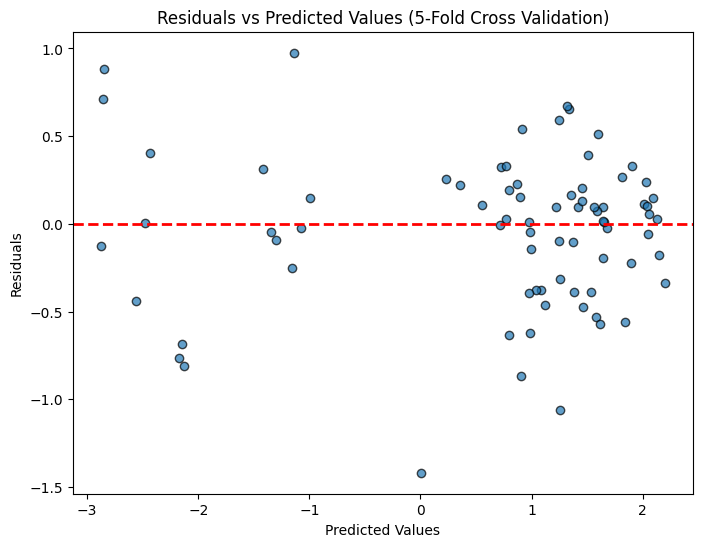

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get feature names
feature_names = X.columns

# Reorder feature names to align with feature importance rankings
sorted_feature_names = feature_names[indices]

# 1. Visualizing Feature Importance
plt.figure(figsize=(10, 6))
plt.title(f'Feature Importances for Top 10 Features')

# Plot a bar chart, with X-axis displaying feature names
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), sorted_feature_names[:10], rotation=90)  # Use feature names instead of numbers
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Use the optimal number of features for 5-fold cross-validation and combine predictions
selected_features_optimal = X_scaled[:, indices[:best_n_features]]

# Store the true and predicted values for each fold
y_true_all = []
y_pred_all = []

# 5-fold cross-validation
for train_index, test_index in kf.split(selected_features_optimal):
    X_train, X_test = selected_features_optimal[train_index], selected_features_optimal[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    et.fit(X_train, y_train)
    
    # Predict
    y_pred = et.predict(X_test)
    
    # Combine true and predicted values
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert y_true_all and y_pred_all to NumPy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Calculate cross-validation evaluation metrics
mae_cv, rmse_cv, mse_cv, r2_cv = evaluate_model(y_true_all, y_pred_all)

# Plot comparison of true values and predicted values, including evaluation metrics
plt.figure(figsize=(8, 6))
plt.scatter(y_true_all, y_pred_all, edgecolor='k', alpha=0.7)
plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--', lw=2)
plt.title('True Values vs Predicted Values (5-Fold Cross Validation)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Add evaluation metrics to the plot
plt.text(0.05, 0.9, f'MAE: {mae_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.85, f'RMSE: {rmse_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.80, f'R²: {r2_cv:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

# Create a DataFrame with true and predicted values
results_df = pd.DataFrame({
    'True_Values': y_true_all,
    'Predicted_Values': y_pred_all
})

# Save the DataFrame as a CSV file
results_df.to_csv('true_vs_predicted_values.csv', index=False)

print("Data has been saved to 'true_vs_predicted_values_comb.csv'")

# 3. Residual Plot (Based on 5-fold cross-validation)
residuals = y_true_all - y_pred_all
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_all, residuals, edgecolor='k', alpha=0.7)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values (5-Fold Cross Validation)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


# SHAP Feature Importance and Value Distribution for Top 6 Features

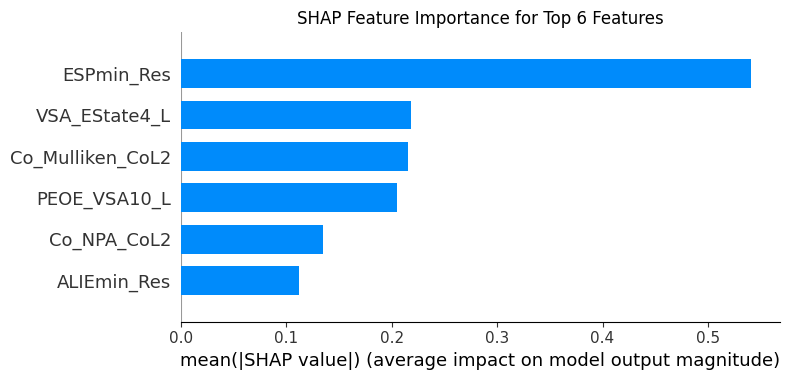

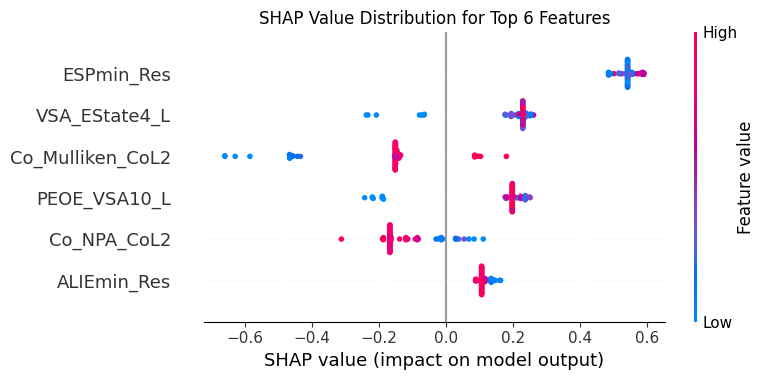

In [22]:
import shap
import matplotlib.pyplot as plt

# Assuming X is your feature dataset and et is your trained ExtraTreesRegressor model

# Select the top 6 most important features
top_6_features = X.columns[indices[:6]]
X_top_6 = X[top_6_features]

# Create a SHAP explainer
explainer = shap.TreeExplainer(et)

# Calculate SHAP values
shap_values = explainer.shap_values(X_top_6)

# Plot SHAP summary (bar chart)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_top_6, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Top 6 Features")
plt.tight_layout()
plt.show()

# Plot SHAP value distribution
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_top_6, show=False)
plt.title("SHAP Value Distribution for Top 6 Features")
plt.tight_layout()
plt.show()


# Save Selected Important Features and Target Labels to CSV

In [23]:
from sklearn.ensemble import GradientBoostingRegressor
import joblib
import pandas as pd

# Feature column names from the training data
feature_names = X.columns  # These are the column names of X used during training

# Get the most important features from the training data
selected_feature_names = feature_names[indices[:best_n_features]]  # Names of the top 'best_n_features' features

# Extract these selected features from the original data
X_selected = X[selected_feature_names]

# Save the selected features and labels to a CSV file
training_data_with_labels = pd.concat([X_selected, y], axis=1)
training_data_with_labels.to_csv('selected_features_and_labels.csv', index=False)
print(f"The selected features and labels have been saved as 'selected_features_and_labels.csv'")

print(f"The top {best_n_features} important features selected are: {selected_feature_names}")


The selected features and labels have been saved as 'selected_features_and_labels.csv'
The top 6 important features selected are: Index(['ESPmin_Res', 'ALIEmin_Res', 'Co_Mulliken_CoL2', 'PEOE_VSA10_L',
       'VSA_EState4_L', 'Co_NPA_CoL2'],
      dtype='object')


# Model Evaluation Using 5-Fold Cross-Validation on Selected Features

In [24]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Load the data
data = pd.read_csv('selected_features_and_labels.csv')

# Features and target variable
X = data.drop(columns=['ln(dr)'])  # Features are the data excluding the 'ln(dr)' column
y = data['ln(dr)']  # The target variable is 'ln(dr)'

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Initialize the model
et = GradientBoostingRegressor(random_state=50)
# et = RandomForestRegressor(random_state=50)

# Lists to store evaluation metrics for each fold
maes, rmses, mses, r2s = [], [], [], []

# Define evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mse, r2

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    et.fit(X_train, y_train)
    
    # Make predictions
    y_pred = et.predict(X_test)
    
    # Evaluate the model
    mae, rmse, mse, r2 = evaluate_model(y_test, y_pred)
    maes.append(mae)
    rmses.append(rmse)
    mses.append(mse)
    r2s.append(r2)

# Calculate and output the average evaluation metrics
results = {
    'MAE': np.mean(maes),
    'RMSE': np.mean(rmses),
    'MSE': np.mean(mses),
    'R2': np.mean(r2s)
}

# Convert to DataFrame for display
results_df = pd.DataFrame([results])

# Print evaluation results
print("Model Evaluation Metrics:")
print(results_df)


Model Evaluation Metrics:
        MAE      RMSE       MSE        R2
0  0.324412  0.421781  0.187081  0.905028


# Predicting New Data Using Trained Model

In [25]:
import joblib
joblib.dump(et, 'new_gradient_boosting_model.pkl')
# joblib.dump(scaler, 'scaler.pkl')


['new_gradient_boosting_model.pkl']

In [26]:
import pandas as pd
# from sklearn.preprocessing import StandardScaler

# 1. Load new data from Test_Descriptors.csv
test_data = pd.read_csv('Test_Descriptors.csv')

# Extract Ligand ID
ligand_ids = test_data['Ligand ID']

# 2. Load the feature data from the training stage
# Assume we know the features used during training from selected_features_and_labels.csv
train_data = pd.read_csv('selected_features_and_labels.csv')

# Get the feature names used during training
selected_feature_names = train_data.drop(columns=['ln(dr)']).columns

# 3. Select features from Test_Descriptors.csv that match the model
X_test = test_data[selected_feature_names]  # Select only the features used in model training

# 4. Load the saved model and scaler (assuming you saved these previously)
model = joblib.load('new_gradient_boosting_model.pkl')
# scaler = joblib.load('scaler.pkl')

# 5. Standardize the new data (using the same scaler as the training data)
# X_test_scaled = scaler.transform(X_test)

# 6. Use the loaded model to make predictions
y_pred = model.predict(X_test)

# 7. Output the prediction results along with the Ligand ID column
results_df = pd.DataFrame({
    'Ligand ID': ligand_ids,
    'Predicted ln(dr)': y_pred
})

# Save the prediction results to a CSV file
results_filename = 'predicted_results.csv'
results_df.to_csv(results_filename, index=False)

print(f"Prediction results have been saved to {results_filename}")


Prediction results have been saved to predicted_results.csv
